In [85]:
import itertools
import optuna
import random
from collections import Counter
from itertools import product

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential

import plotly.graph_objects as go
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Lectura de datos + train/validation/test

In [2]:
# Semillas
np.random.seed(42)  
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
random.seed(42)

# Cargar el dataset
train = pd.read_csv("./data/datasets/train.csv")
validation = pd.read_csv("./data/datasets/validation.csv")
test = pd.read_csv("./data/datasets/test.csv")

train.shape, validation.shape, test.shape

((5760, 6), (1080, 6), (1080, 6))

In [3]:
train["class"].value_counts(), validation["class"].value_counts(), test["class"].value_counts()

(class
 0    5664
 1      96
 Name: count, dtype: int64,
 class
 0    1062
 1      18
 Name: count, dtype: int64,
 class
 0    1062
 1      18
 Name: count, dtype: int64)

In [4]:
# Separar las características y la variable objetivo
feature_cols = ["interval", "spikes", "differenceSpikes_1"]

######################################################################
###################### TRAIN, VALIDATION Y TEST ######################
######################################################################

X_train = train[feature_cols]
y_train = train["class"]

# Calcular pesos para manejar el desbalance de clases
class_weight = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

X_val = validation[feature_cols]
y_val = validation["class"]

X_test = test[feature_cols]
y_test = test["class"]

# Para los algoritmos que requieran de normalización, se generan los conjuntos de datos correspondientes

# Instanciar StandardScaler
scaler = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento (evita data leakage)
scaler.fit(X_train)

# Transformar los conjuntos de datos con los mismos parámetros
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener estructura original
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

## Regresión Logística

In [5]:
######################################################################
##################### BÚSQUEDA DE HIPERPARÁMETROS ####################
######################################################################

# Inicializar variables para almacenar los mejores hiperparámetros
best_params = None
best_score = -float('inf')

# Espacio de búsqueda de hiperparámetros
param_grid = {   
    'max_iter': [75, 100, 125, 150]
}

# Generar todas las combinaciones posibles de hiperparámetros
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Probar cada combinación de hiperparámetros
for params in combinations:
    # Crear y ajustar el modelo con los hiperparámetros actuales
    model = LogisticRegression(
        penalty=None,
        random_state=42,
        class_weight="balanced",
        **params
    )
    model.fit(X_train_scaled, y_train)
    
    # Predecir en el conjunto de validación
    y_val_pred = model.predict(X_val_scaled)
    
    # Calcular la métrica de evaluación (F1-score en este caso)
    score = f1_score(y_val, y_val_pred)
    
    # Almacenar los hiperparámetros si el modelo mejora
    if score > best_score:
        best_score = score
        best_params = params

# Mostrar los mejores hiperparámetros y la métrica obtenida
print("Mejores hiperparámetros:", best_params)
print("Mejor F1-score (Validación):", best_score)

Mejores hiperparámetros: {'max_iter': 75}
Mejor F1-score (Validación): 0.5454545454545454


In [6]:
######################################################################
###################### REGRESIÓN LOGÍSTICA ###########################
######################################################################

# Definir los mejores hiperparámetros encontrados
logreg = LogisticRegression(
    max_iter=75, 
    random_state=42, 
    class_weight="balanced"
)

# Entrenar el modelo con los datos de entrenamiento
logreg.fit(X_train_scaled, y_train)

# Train
y_train_pred = logreg.predict(X_train_scaled)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
print("Matriz de confusión (Train):")
print(cnf_matrix_train)

# Informe de clasificación en el conjunto de train
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_train, y_train_pred, target_names=target_names, digits=3))

# Validation
y_val_pred = logreg.predict(X_val_scaled)
cnf_matrix_val = metrics.confusion_matrix(y_val, y_val_pred)
print("Matriz de confusión (Validation):")
print(cnf_matrix_val)

# Informe de clasificación en el conjunto de validation
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_val, y_val_pred, target_names=target_names, digits=3))

# Test
y_pred = logreg.predict(X_test_scaled)
cnf_matrix_test = metrics.confusion_matrix(y_test, y_pred)
print("Matriz de confusión (Test):")
print(cnf_matrix_test)

# Informe de clasificación en el conjunto de test
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_test, y_pred, target_names=target_names, digits=3))

Matriz de confusión (Train):
[[5603   61]
 [   0   96]]
              precision    recall  f1-score   support

      Normal      1.000     0.989     0.995      5664
      Ataque      0.611     1.000     0.759        96

    accuracy                          0.989      5760
   macro avg      0.806     0.995     0.877      5760
weighted avg      0.994     0.989     0.991      5760

Matriz de confusión (Validation):
[[1032   30]
 [   0   18]]
              precision    recall  f1-score   support

      Normal      1.000     0.972     0.986      1062
      Ataque      0.375     1.000     0.545        18

    accuracy                          0.972      1080
   macro avg      0.688     0.986     0.766      1080
weighted avg      0.990     0.972     0.978      1080

Matriz de confusión (Test):
[[1050   12]
 [   0   18]]
              precision    recall  f1-score   support

      Normal      1.000     0.989     0.994      1062
      Ataque      0.600     1.000     0.750        18

    accura

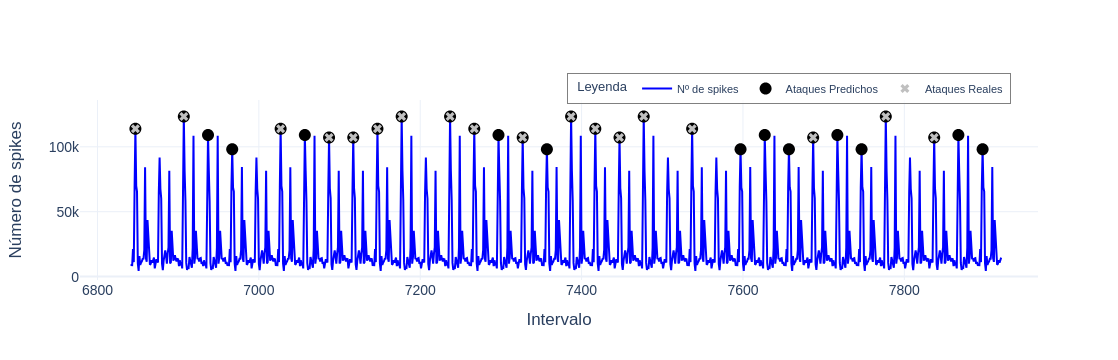

In [70]:
# Convertir y_pred en DataFrame si no lo es
df_y_pred = pd.DataFrame(y_pred, columns=['class'])

# Convertir y_test en DataFrame
df_y_test = y_test.to_frame(name='true_class').reset_index(drop=True)

# Asegurar que X_test tiene el mismo índice que y_test
df_final = X_test.reset_index(drop=True).copy()
df_final['class'] = df_y_pred['class']  # Agregar predicciones
df_final['true_class'] = df_y_test['true_class']  # Agregar valores reales

# Crear la figura con Plotly
fig = go.Figure()

# Agregar la serie de tiempo (línea azul para los spikes) SIN que aparezca en la leyenda
fig.add_trace(go.Scatter(
    x=df_final['interval'],
    y=df_final['spikes'],
    mode='lines',
    name='Nº de spikes',
    line=dict(color='blue')
))

# Filtrar los ataques predichos (class == 1)
df_attacks_pred = df_final[df_final['class'] == 1]

# Agregar los ataques predichos en negro si existen
if not df_attacks_pred.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_pred['interval'],
        y=df_attacks_pred['spikes'],
        mode='markers',
        name='Ataques Predichos',
        marker=dict(color='black', size=12, symbol='circle')
    ))

# Filtrar los ataques reales (true_class == 1)
df_attacks_true = df_final[df_final['true_class'] == 1]

# Agregar los ataques reales en plateado si existen
if not df_attacks_true.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_true['interval'],
        y=df_attacks_true['spikes'],
        mode='markers',
        name='Ataques Reales',
        marker=dict(color='silver', size=8, symbol='x')  # Puntos plateados
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis=dict(
        title="Intervalo",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje X
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje X
    ),
    yaxis=dict(
        title="Número de spikes",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje Y
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje Y
    ),
    legend=dict(
        title="  Leyenda",
        font=dict(size=11),
        x=0.74,  # Centrar en la parte inferior
        y=1.15,  # Colocar debajo del gráfico
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)", 
        bordercolor="gray",  # Color del borde
        borderwidth=1.0,  # Ancho del borde
        orientation="h"  # Leyenda en horizontal
    ),
    template="plotly_white"
)

# Mostrar la gráfica
fig.show()

## SVC

In [79]:
######################################################################
##################### BÚSQUEDA DE HIPERPARÁMETROS ####################
######################################################################

# Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 5],            # Mayor rango de regularización
    'kernel': ["linear", "rbf"],  # Evaluamos dos kernels
    'gamma': ["scale", 0.01, 0.1] # Solo afecta a "rbf"
}

# Generar combinaciones de hiperparámetros
combinations = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())]

# Variables para almacenar los mejores hiperparámetros
best_params = None
best_score = -float('inf')

# Búsqueda manual con el conjunto de validación
for params in combinations:
    if params["kernel"] == "linear":
        params.pop("gamma")  # Eliminar gamma si el kernel es "linear"

    print(f"Probando: {params}")  # Seguimiento de la búsqueda
    
    # Crear el modelo con los hiperparámetros actuales
    svc = SVC(
        random_state=42,
        class_weight="balanced",
        **params
    )
    
    # Ajustar el modelo
    svc.fit(X_train_scaled, y_train)

    # Evaluación en el conjunto de validación
    y_val_pred = svc.predict(X_val_scaled)
    score = f1_score(y_val, y_val_pred)  # Usamos F1-score para manejar el desbalance
    
    # Guardar los mejores hiperparámetros
    if score > best_score:
        best_score = score
        best_params = params

print("\nMejores hiperparámetros encontrados:", best_params)
print("Mejor F1-score (Validación):", best_score)

Probando: {'C': 0.1, 'kernel': 'linear'}
Probando: {'C': 0.1, 'kernel': 'linear'}
Probando: {'C': 0.1, 'kernel': 'linear'}
Probando: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
Probando: {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.01}
Probando: {'C': 0.1, 'kernel': 'rbf', 'gamma': 0.1}
Probando: {'C': 1, 'kernel': 'linear'}
Probando: {'C': 1, 'kernel': 'linear'}
Probando: {'C': 1, 'kernel': 'linear'}
Probando: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
Probando: {'C': 1, 'kernel': 'rbf', 'gamma': 0.01}
Probando: {'C': 1, 'kernel': 'rbf', 'gamma': 0.1}
Probando: {'C': 5, 'kernel': 'linear'}
Probando: {'C': 5, 'kernel': 'linear'}
Probando: {'C': 5, 'kernel': 'linear'}
Probando: {'C': 5, 'kernel': 'rbf', 'gamma': 'scale'}
Probando: {'C': 5, 'kernel': 'rbf', 'gamma': 0.01}
Probando: {'C': 5, 'kernel': 'rbf', 'gamma': 0.1}

Mejores hiperparámetros encontrados: {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
Mejor F1-score (Validación): 0.8571428571428571


In [80]:
######################################################################
########################## SVC #######################################
######################################################################

# Entrenar modelo final con los mejores hiperparámetros encontrados
final_svc = SVC(
    C=1, 
    kernel="rbf", 
    gamma="scale", 
    class_weight="balanced", 
    random_state=42
)
final_svc.fit(X_train_scaled, y_train)

# Train
y_train_pred = final_svc.predict(X_train_scaled)
print("Matriz de confusión (Train):")
print(confusion_matrix(y_train, y_train_pred))

target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_train, y_train_pred, target_names=target_names, digits=3))

# Validation
y_val_pred = final_svc.predict(X_val_scaled)
print("Matriz de confusión (Validation):")
print(confusion_matrix(y_val, y_val_pred))

target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_val, y_val_pred, target_names=target_names, digits=3))

# Test
y_pred = final_svc.predict(X_test_scaled)
print("Matriz de confusión (Test):")
print(confusion_matrix(y_test, y_pred))

target_names = ['Normal', 'Ataque']
print("Informe de clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Matriz de confusión (Train):
[[5627   37]
 [   0   96]]
              precision    recall  f1-score   support

      Normal      1.000     0.993     0.997      5664
      Ataque      0.722     1.000     0.838        96

    accuracy                          0.994      5760
   macro avg      0.861     0.997     0.918      5760
weighted avg      0.995     0.994     0.994      5760

Matriz de confusión (Validation):
[[1056    6]
 [   0   18]]
              precision    recall  f1-score   support

      Normal      1.000     0.994     0.997      1062
      Ataque      0.750     1.000     0.857        18

    accuracy                          0.994      1080
   macro avg      0.875     0.997     0.927      1080
weighted avg      0.996     0.994     0.995      1080

Matriz de confusión (Test):
[[1044   18]
 [   0   18]]
Informe de clasificación (Test):
              precision    recall  f1-score   support

      Normal      1.000     0.983     0.991      1062
      Ataque      0.500     1.00

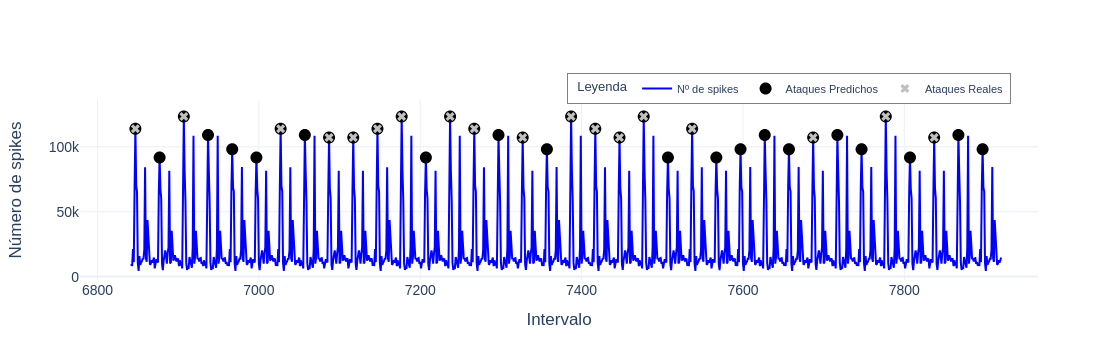

In [81]:
# Convertir y_pred en DataFrame si no lo es
df_y_pred = pd.DataFrame(y_pred, columns=['class'])

# Convertir y_test en DataFrame
df_y_test = y_test.to_frame(name='true_class').reset_index(drop=True)

# Asegurar que X_test tiene el mismo índice que y_test
df_final = X_test.reset_index(drop=True).copy()
df_final['class'] = df_y_pred['class']  # Agregar predicciones
df_final['true_class'] = df_y_test['true_class']  # Agregar valores reales

# Crear la figura con Plotly
fig = go.Figure()

# Agregar la serie de tiempo (línea azul para los spikes) SIN que aparezca en la leyenda
fig.add_trace(go.Scatter(
    x=df_final['interval'],
    y=df_final['spikes'],
    mode='lines',
    name='Nº de spikes',
    line=dict(color='blue')
))

# Filtrar los ataques predichos (class == 1)
df_attacks_pred = df_final[df_final['class'] == 1]

# Agregar los ataques predichos en negro si existen
if not df_attacks_pred.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_pred['interval'],
        y=df_attacks_pred['spikes'],
        mode='markers',
        name='Ataques Predichos',
        marker=dict(color='black', size=12, symbol='circle')
    ))

# Filtrar los ataques reales (true_class == 1)
df_attacks_true = df_final[df_final['true_class'] == 1]

# Agregar los ataques reales en plateado si existen
if not df_attacks_true.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_true['interval'],
        y=df_attacks_true['spikes'],
        mode='markers',
        name='Ataques Reales',
        marker=dict(color='silver', size=8, symbol='x')  # Puntos plateados
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis=dict(
        title="Intervalo",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje X
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje X
    ),
    yaxis=dict(
        title="Número de spikes",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje Y
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje Y
    ),
    legend=dict(
        title="  Leyenda",
        font=dict(size=11),
        x=0.74,  # Centrar en la parte inferior
        y=1.15,  # Colocar debajo del gráfico
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)", 
        bordercolor="gray",  # Color del borde
        borderwidth=1.0,  # Ancho del borde
        orientation="h"  # Leyenda en horizontal
    ),
    template="plotly_white"
)

# Mostrar la gráfica
fig.show()

## Random Forest

In [74]:
######################################################################
##################### BÚSQUEDA DE HIPERPARÁMETROS ####################
######################################################################

# Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [2, 5, 10],
}

# Generar combinaciones de hiperparámetros
combinations = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())]

# Variables para almacenar los mejores hiperparámetros
best_params = None
best_score = -float('inf')

# Búsqueda manual con el conjunto de validación
for params in combinations:
    print(f"Probando: {params}")  # Seguimiento de la búsqueda
    
    # Crear el modelo con los hiperparámetros actuales
    rf = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        **params
    )
    
    # Ajustar el modelo
    rf.fit(X_train, y_train)

    # Evaluación en el conjunto de validación
    y_val_pred = rf.predict(X_val)
    score = f1_score(y_val, y_val_pred)  # Se usa F1-score para manejar el desbalance
    
    # Guardar los mejores hiperparámetros
    if score > best_score:
        best_score = score
        best_params = params

print("\nMejores hiperparámetros encontrados:", best_params)
print("Mejor F1-score (Validación):", best_score)

Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 10}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 10}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5}
Probando: {'n_estimators': 50, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10}
Probando: {'n_estimators': 50, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2}
Probando: {'n_estimators': 50, 'max_depth': 5, 'max_features': 

In [75]:
######################################################################
########################## RANDOM FOREST #############################
######################################################################

# Entrenar modelo final con los mejores hiperparámetros encontrados
final_rf = RandomForestClassifier(
    class_weight="balanced", 
    random_state=42,
    n_estimators=50,
    max_depth=3,
    max_features = "sqrt",
    min_samples_leaf=5
)

final_rf.fit(X_train, y_train)

# Train
y_train_pred = final_rf.predict(X_train)
print("Matriz de confusión (Train):")
print(confusion_matrix(y_train, y_train_pred))

# Informe de clasificación en el conjunto de train
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_train, y_train_pred, target_names=target_names, digits=3))

# Validation
y_val_pred = final_rf.predict(X_val)
print("Matriz de confusión (Validation):")
print(confusion_matrix(y_val, y_val_pred))

# Informe de clasificación en el conjunto de validation
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_val, y_val_pred, target_names=target_names, digits=3))

# Test
y_pred = final_rf.predict(X_test)
print("Matriz de confusión (Test):")
print(confusion_matrix(y_test, y_pred))

# Informe de clasificación en el conjunto de test
target_names = ['Normal', 'Ataque']
print("Informe de clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Matriz de confusión (Train):
[[5640   24]
 [   0   96]]
              precision    recall  f1-score   support

      Normal      1.000     0.996     0.998      5664
      Ataque      0.800     1.000     0.889        96

    accuracy                          0.996      5760
   macro avg      0.900     0.998     0.943      5760
weighted avg      0.997     0.996     0.996      5760

Matriz de confusión (Validation):
[[1056    6]
 [   0   18]]
              precision    recall  f1-score   support

      Normal      1.000     0.994     0.997      1062
      Ataque      0.750     1.000     0.857        18

    accuracy                          0.994      1080
   macro avg      0.875     0.997     0.927      1080
weighted avg      0.996     0.994     0.995      1080

Matriz de confusión (Test):
[[1044   18]
 [   0   18]]
Informe de clasificación (Test):
              precision    recall  f1-score   support

      Normal      1.000     0.983     0.991      1062
      Ataque      0.500     1.00

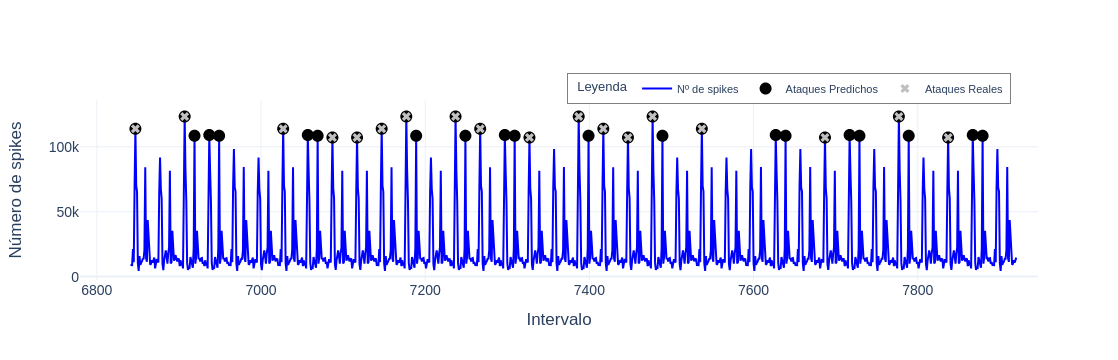

In [76]:
# Convertir y_pred en DataFrame si no lo es
df_y_pred = pd.DataFrame(y_pred, columns=['class'])

# Convertir y_test en DataFrame
df_y_test = y_test.to_frame(name='true_class').reset_index(drop=True)

# Asegurar que X_test tiene el mismo índice que y_test
df_final = X_test.reset_index(drop=True).copy()
df_final['class'] = df_y_pred['class']  # Agregar predicciones
df_final['true_class'] = df_y_test['true_class']  # Agregar valores reales

# Crear la figura con Plotly
fig = go.Figure()

# Agregar la serie de tiempo (línea azul para los spikes) SIN que aparezca en la leyenda
fig.add_trace(go.Scatter(
    x=df_final['interval'],
    y=df_final['spikes'],
    mode='lines',
    name='Nº de spikes',
    line=dict(color='blue')
))

# Filtrar los ataques predichos (class == 1)
df_attacks_pred = df_final[df_final['class'] == 1]

# Agregar los ataques predichos en negro si existen
if not df_attacks_pred.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_pred['interval'],
        y=df_attacks_pred['spikes'],
        mode='markers',
        name='Ataques Predichos',
        marker=dict(color='black', size=12, symbol='circle')
    ))

# Filtrar los ataques reales (true_class == 1)
df_attacks_true = df_final[df_final['true_class'] == 1]

# Agregar los ataques reales en plateado si existen
if not df_attacks_true.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_true['interval'],
        y=df_attacks_true['spikes'],
        mode='markers',
        name='Ataques Reales',
        marker=dict(color='silver', size=8, symbol='x')  # Puntos plateados
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis=dict(
        title="Intervalo",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje X
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje X
    ),
    yaxis=dict(
        title="Número de spikes",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje Y
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje Y
    ),
    legend=dict(
        title="  Leyenda",
        font=dict(size=11),
        x=0.74,  # Centrar en la parte inferior
        y=1.15,  # Colocar debajo del gráfico
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)", 
        bordercolor="gray",  # Color del borde
        borderwidth=1.0,  # Ancho del borde
        orientation="h"  # Leyenda en horizontal
    ),
    template="plotly_white"
)

# Mostrar la gráfica
fig.show()

## XGBoost

In [71]:
######################################################################
##################### BÚSQUEDA DE HIPERPARÁMETROS ####################
######################################################################

# Calcular scale_pos_weight para manejar desbalance de clases
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

param_grid = {
    'max_depth': [2, 3],              # Árboles poco profundos para evitar sobreajuste en series temporales
    'learning_rate': [0.025, 0.05],   # Tasa de aprendizaje baja para ajustes graduales
    'n_estimators': [50, 100],        # Más árboles para compensar el learning rate bajo
    'gamma': [0.6, 0.8],              # Mayor penalización para divisiones innecesarias
    'min_child_weight': [75, 100, 125],    # Evita divisiones con pocos datos
    'subsample': [0.5, 0.7, 1.0],               # Evitar muestreo aleatorio para preservar la secuencia temporal
}


# Generar combinaciones de hiperparámetros
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Inicializar variables para almacenar los mejores hiperparámetros
best_params = None
best_score = -float('inf')

# Probar cada combinación de hiperparámetros
for params in combinations:
    print(f"Probando: {params}")  # Para seguimiento
    
    # Crear el modelo con los hiperparámetros actuales
    xgb = XGBClassifier(
        scale_pos_weight = scale_pos_weight,
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        **params
    )
    
    # Ajustar el modelo con sample_weight
    xgb.fit(X_train, y_train)

    # Evaluación en el conjunto de validación
    y_val_pred = xgb.predict(X_val)
    score = f1_score(y_val, y_val_pred)  # Usamos F1-score para problemas desbalanceados
    
    # Almacenar la mejor combinación de hiperparámetros
    if score > best_score:
        best_score = score
        best_params = params

print("\nMejores hiperparámetros:", best_params)
print("Mejor F1-score (Validación):", best_score)

Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 75, 'subsample': 0.5}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 75, 'subsample': 0.7}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 75, 'subsample': 1.0}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 100, 'subsample': 0.5}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 100, 'subsample': 0.7}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 100, 'subsample': 1.0}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 125, 'subsample': 0.5}
Probando: {'max_depth': 2, 'learning_rate': 0.025, 'n_estimators': 50, 'gamma': 0.6, 'min_child_weight': 12

In [72]:
######################################################################
######################### MODELO XGBOOST #############################
######################################################################

# Calcular scale_pos_weight para manejar desbalanceo de clases
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Modelo XGBoost con fuerte regularización para evitar overfitting
xgb = XGBClassifier(
    max_depth=2,              
    learning_rate=0.025,         
    n_estimators=50,  
    gamma = 0.6,
    min_child_weight= 75,       
    subsample=0.5,
    scale_pos_weight=scale_pos_weight,  # Balancea la clase minoritaria
    random_state=42,
    eval_metric="logloss"
)

# Ajustar el modelo
xgb.fit(X_train, y_train)

# Train
y_train_pred = xgb.predict(X_train)
print("Matriz de confusión (Train):")
print(confusion_matrix(y_train, y_train_pred))

# Informe de clasificación en el conjunto de train
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_train, y_train_pred, target_names=target_names, digits=3))

# Validation
y_val_pred = xgb.predict(X_val)
print("Matriz de confusión (Validation):")
print(confusion_matrix(y_val, y_val_pred))

# Informe de clasificación en el conjunto de validation
target_names = ['Normal', 'Ataque']
print(metrics.classification_report(y_val, y_val_pred, target_names=target_names, digits=3))

# Test
y_pred = xgb.predict(X_test)
print("Matriz de confusión (Test):")
print(confusion_matrix(y_test, y_pred))

# Informe de clasificación en el conjunto de test
target_names = ['Normal', 'Ataque']
print("Informe de clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

Matriz de confusión (Train):
[[5568   96]
 [   0   96]]
              precision    recall  f1-score   support

      Normal      1.000     0.983     0.991      5664
      Ataque      0.500     1.000     0.667        96

    accuracy                          0.983      5760
   macro avg      0.750     0.992     0.829      5760
weighted avg      0.992     0.983     0.986      5760

Matriz de confusión (Validation):
[[1056    6]
 [   0   18]]
              precision    recall  f1-score   support

      Normal      1.000     0.994     0.997      1062
      Ataque      0.750     1.000     0.857        18

    accuracy                          0.994      1080
   macro avg      0.875     0.997     0.927      1080
weighted avg      0.996     0.994     0.995      1080

Matriz de confusión (Test):
[[1044   18]
 [   0   18]]
Informe de clasificación (Test):
              precision    recall  f1-score   support

      Normal      1.000     0.983     0.991      1062
      Ataque      0.500     1.00

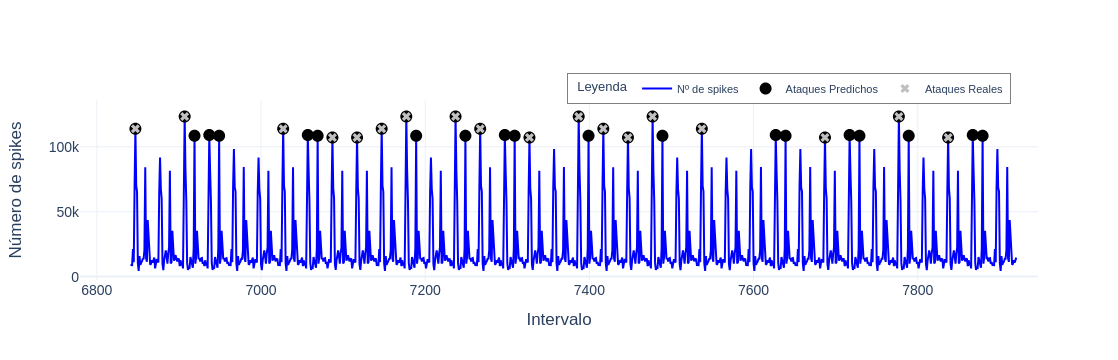

In [73]:
# Convertir y_pred en DataFrame si no lo es
df_y_pred = pd.DataFrame(y_pred, columns=['class'])

# Convertir y_test en DataFrame
df_y_test = y_test.to_frame(name='true_class').reset_index(drop=True)

# Asegurar que X_test tiene el mismo índice que y_test
df_final = X_test.reset_index(drop=True).copy()
df_final['class'] = df_y_pred['class']  # Agregar predicciones
df_final['true_class'] = df_y_test['true_class']  # Agregar valores reales

# Crear la figura con Plotly
fig = go.Figure()

# Agregar la serie de tiempo (línea azul para los spikes) SIN que aparezca en la leyenda
fig.add_trace(go.Scatter(
    x=df_final['interval'],
    y=df_final['spikes'],
    mode='lines',
    name='Nº de spikes',
    line=dict(color='blue')
))

# Filtrar los ataques predichos (class == 1)
df_attacks_pred = df_final[df_final['class'] == 1]

# Agregar los ataques predichos en negro si existen
if not df_attacks_pred.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_pred['interval'],
        y=df_attacks_pred['spikes'],
        mode='markers',
        name='Ataques Predichos',
        marker=dict(color='black', size=12, symbol='circle')
    ))

# Filtrar los ataques reales (true_class == 1)
df_attacks_true = df_final[df_final['true_class'] == 1]

# Agregar los ataques reales en plateado si existen
if not df_attacks_true.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_true['interval'],
        y=df_attacks_true['spikes'],
        mode='markers',
        name='Ataques Reales',
        marker=dict(color='silver', size=8, symbol='x')  # Puntos plateados
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis=dict(
        title="Intervalo",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje X
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje X
    ),
    yaxis=dict(
        title="Número de spikes",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje Y
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje Y
    ),
    legend=dict(
        title="  Leyenda",
        font=dict(size=11),
        x=0.74,  # Centrar en la parte inferior
        y=1.15,  # Colocar debajo del gráfico
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)", 
        bordercolor="gray",  # Color del borde
        borderwidth=1.0,  # Ancho del borde
        orientation="h"  # Leyenda en horizontal
    ),
    template="plotly_white"
)

# Mostrar la gráfica
fig.show()

## MLP

In [15]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
random.seed(42)

# Definir la métrica de evaluación: F1-score
def f1_m(y_true, y_pred):
    """ Calcula F1-score en Keras """
    y_true = K.cast(y_true, "float32")  # Convertir etiquetas a float32
    y_pred = K.cast(K.round(y_pred), "float32")  # Convertir predicciones a binario

    tp = K.sum(y_true * y_pred)  # Verdaderos Positivos
    fp = K.sum((1 - y_true) * y_pred)  # Falsos Positivos
    fn = K.sum(y_true * (1 - y_pred))  # Falsos Negativos

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())


def create_model(trial):
    """ Define el modelo de red neuronal con hiperparámetros optimizables """
    model = keras.Sequential()

    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    
    # Número de capas ocultas
    n_layers = trial.suggest_int("n_layers", 1, 4)
    for i in range(n_layers):
        model.add(keras.layers.Dense(
            units=trial.suggest_categorical(f"units_l{i}", [8, 16, 32, 64, 128]),  # Solo prueba estos valores
            activation="relu"
        ))
        # Dropout solo si Optuna lo sugiere como True
        if trial.suggest_categorical(f"dropout_{i}", [True, False]):
            model.add(keras.layers.Dropout(trial.suggest_float(f"dropout_rate_{i}", 0.15, 0.3)))
    
    # Capa de salida
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Fijamos Adam como optimizador
    model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=[f1_m])
    
    return model

def objective(trial):
    """ Función de evaluación para Optuna con PR-AUC """
    model = create_model(trial)
    
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    
    # Entrenamiento del modelo
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
              epochs=20, batch_size=batch_size, verbose=0,
              class_weight=class_weight)
    
    # Predicción de probabilidades en validación
    y_pred = model.predict(X_val_scaled).ravel()

    # Calcular PR-AUC como métrica de optimización
    return average_precision_score(y_val, y_pred)

# Búsqueda de hiperparámetros con Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


# Mejor combinación de hiperparámetros encontrada
print("Mejores hiperparámetros:", study.best_params)

[I 2025-03-13 08:18:23,823] A new study created in memory with name: no-name-1cb572f6-043a-4352-b5ab-ebd53035399d


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:18:36,298] Trial 0 finished with value: 0.8895454545454546 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_0': False, 'units_l1': 64, 'dropout_1': False, 'batch_size': 32}. Best is trial 0 with value: 0.8895454545454546.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:18:49,229] Trial 1 finished with value: 0.8895454545454545 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_0': False, 'units_l1': 8, 'dropout_1': False, 'units_l2': 8, 'dropout_2': True, 'dropout_rate_2': 0.27537539517592113, 'batch_size': 32}. Best is trial 0 with value: 0.8895454545454546.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:18:57,648] Trial 2 finished with value: 0.8539806978887439 and parameters: {'n_layers': 3, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.1662721754529055, 'units_l1': 32, 'dropout_1': True, 'dropout_rate_1': 0.16431497949925644, 'units_l2': 16, 'dropout_2': True, 'dropout_rate_2': 0.21682220910310795, 'batch_size': 64}. Best is trial 0 with value: 0.8895454545454546.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:19:11,298] Trial 3 finished with value: 0.8539806978887439 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_0': False, 'units_l1': 128, 'dropout_1': False, 'units_l2': 8, 'dropout_2': True, 'dropout_rate_2': 0.275058449818409, 'batch_size': 32}. Best is trial 0 with value: 0.8895454545454546.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:19:23,694] Trial 4 finished with value: 0.9012443144899287 and parameters: {'n_layers': 2, 'units_l0': 32, 'dropout_0': False, 'units_l1': 16, 'dropout_1': True, 'dropout_rate_1': 0.27094735270890724, 'batch_size': 32}. Best is trial 4 with value: 0.9012443144899287.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:19:37,331] Trial 5 finished with value: 0.9063833001476023 and parameters: {'n_layers': 3, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.20507653247355734, 'units_l1': 16, 'dropout_1': False, 'units_l2': 64, 'dropout_2': True, 'dropout_rate_2': 0.18059852161795906, 'batch_size': 32}. Best is trial 5 with value: 0.9063833001476023.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:19:49,538] Trial 6 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.22957719745986638, 'units_l1': 16, 'dropout_1': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:19:54,485] Trial 7 finished with value: 0.9907216297825173 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:00,524] Trial 8 finished with value: 0.8936332683758315 and parameters: {'n_layers': 2, 'units_l0': 16, 'dropout_0': False, 'units_l1': 32, 'dropout_1': True, 'dropout_rate_1': 0.17589094979460856, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:11,755] Trial 9 finished with value: 0.9063833001476023 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.15386577359688386, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-13 08:20:19,501] Trial 10 finished with value: 0.8765157965349535 and parameters: {'n_layers': 4, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.2892787668024883, 'units_l1': 16, 'dropout_1': False, 'units_l2': 32, 'dropout_2': False, 'units_l3': 8, 'dropout_3': True, 'dropout_rate_3': 0.22324233203648725, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:25,056] Trial 11 finished with value: 0.9496572499281477 and parameters: {'n_layers': 1, 'units_l0': 64, 'dropout_0': True, 'dropout_rate_0': 0.2582679637086078, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:30,283] Trial 12 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:35,606] Trial 13 finished with value: 0.9387626262626263 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.22861282092779542, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:47,070] Trial 14 finished with value: 0.9476324229033207 and parameters: {'n_layers': 2, 'units_l0': 8, 'dropout_0': False, 'units_l1': 128, 'dropout_1': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:20:52,161] Trial 15 finished with value: 0.902109795874098 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.2137823444039987, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:04,062] Trial 16 finished with value: 0.8666300107121363 and parameters: {'n_layers': 2, 'units_l0': 16, 'dropout_0': False, 'units_l1': 8, 'dropout_1': True, 'dropout_rate_1': 0.29844147473179833, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-13 08:21:12,239] Trial 17 finished with value: 0.8668557906792955 and parameters: {'n_layers': 4, 'units_l0': 64, 'dropout_0': True, 'dropout_rate_0': 0.25113663072325415, 'units_l1': 64, 'dropout_1': False, 'units_l2': 128, 'dropout_2': False, 'units_l3': 16, 'dropout_3': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:17,694] Trial 18 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.19389118524938134, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:29,099] Trial 19 finished with value: 0.8997105244530874 and parameters: {'n_layers': 2, 'units_l0': 8, 'dropout_0': False, 'units_l1': 16, 'dropout_1': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:34,286] Trial 20 finished with value: 0.7332640357835191 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:39,436] Trial 21 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.18625031676040887, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:44,610] Trial 22 finished with value: 0.9907216297825173 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.19025044941068445, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:50,805] Trial 23 finished with value: 0.9615358521576272 and parameters: {'n_layers': 2, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.23824268625547565, 'units_l1': 16, 'dropout_1': True, 'dropout_rate_1': 0.22428758611017602, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:21:55,934] Trial 24 finished with value: 0.9549351228166233 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.2685081640120865, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:02,327] Trial 25 finished with value: 0.9047166334809355 and parameters: {'n_layers': 2, 'units_l0': 16, 'dropout_0': True, 'dropout_rate_0': 0.18693467218319845, 'units_l1': 8, 'dropout_1': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:13,788] Trial 26 finished with value: 0.9030056834004201 and parameters: {'n_layers': 1, 'units_l0': 64, 'dropout_0': True, 'dropout_rate_0': 0.21145194282764412, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:20,524] Trial 27 finished with value: 0.9795774498883376 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.23646210736194118, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:32,703] Trial 28 finished with value: 0.8737530062530063 and parameters: {'n_layers': 2, 'units_l0': 8, 'dropout_0': False, 'units_l1': 32, 'dropout_1': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:45,543] Trial 29 finished with value: 0.8880924630924631 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_0': False, 'units_l1': 64, 'dropout_1': True, 'dropout_rate_1': 0.22251535277118029, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:52,716] Trial 30 finished with value: 0.9625940532158281 and parameters: {'n_layers': 3, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.17432379073876772, 'units_l1': 128, 'dropout_1': False, 'units_l2': 64, 'dropout_2': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:22:58,159] Trial 31 finished with value: 0.592191577111371 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.19303356264410662, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:03,585] Trial 32 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.1736897862007342, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:09,431] Trial 33 finished with value: 0.9047166334809355 and parameters: {'n_layers': 1, 'units_l0': 128, 'dropout_0': True, 'dropout_rate_0': 0.20397598982996853, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:15,133] Trial 34 finished with value: 0.8319234236043923 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.2283206753419124, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:20,760] Trial 35 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.21836763645498916, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:32,940] Trial 36 finished with value: 0.8895454545454545 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_0': False, 'units_l1': 16, 'dropout_1': True, 'dropout_rate_1': 0.25989293189445944, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:45,690] Trial 37 finished with value: 0.9270718507067052 and parameters: {'n_layers': 3, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.15002984425420438, 'units_l1': 16, 'dropout_1': False, 'units_l2': 32, 'dropout_2': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:51,540] Trial 38 finished with value: 0.8829435570814881 and parameters: {'n_layers': 2, 'units_l0': 16, 'dropout_0': False, 'units_l1': 64, 'dropout_1': False, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:23:59,408] Trial 39 finished with value: 0.8691683248883815 and parameters: {'n_layers': 3, 'units_l0': 64, 'dropout_0': True, 'dropout_rate_0': 0.19758826342117722, 'units_l1': 8, 'dropout_1': True, 'dropout_rate_1': 0.19296790384435875, 'units_l2': 128, 'dropout_2': True, 'dropout_rate_2': 0.15593150192494126, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:10,114] Trial 40 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': False, 'batch_size': 32}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:15,276] Trial 41 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.17408639296687084, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:20,754] Trial 42 finished with value: 0.9824236517218974 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.1805578958305677, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:26,164] Trial 43 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 8, 'dropout_0': True, 'dropout_rate_0': 0.165149018976003, 'batch_size': 64}. Best is trial 6 with value: 1.0.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:31,625] Trial 44 finished with value: 1.0000000000000002 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.16415257030448108, 'batch_size': 64}. Best is trial 44 with value: 1.0000000000000002.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:37,074] Trial 45 finished with value: 0.9795774498883374 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.16550829611628104, 'batch_size': 64}. Best is trial 44 with value: 1.0000000000000002.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:42,490] Trial 46 finished with value: 0.9310923873359374 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.1836807763086189, 'batch_size': 64}. Best is trial 44 with value: 1.0000000000000002.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:24:47,728] Trial 47 finished with value: 0.9591548997766748 and parameters: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.15660949921549347, 'batch_size': 64}. Best is trial 44 with value: 1.0000000000000002.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-03-13 08:25:01,202] Trial 48 finished with value: 0.901248985991549 and parameters: {'n_layers': 4, 'units_l0': 32, 'dropout_0': False, 'units_l1': 32, 'dropout_1': False, 'units_l2': 16, 'dropout_2': False, 'units_l3': 32, 'dropout_3': True, 'dropout_rate_3': 0.29180384524584757, 'batch_size': 32}. Best is trial 44 with value: 1.0000000000000002.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-03-13 08:25:07,616] Trial 49 finished with value: 0.8866109816109815 and parameters: {'n_layers': 2, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.19970719934540967, 'units_l1': 128, 'dropout_1': False, 'batch_size': 64}. Best is trial 44 with value: 1.0000000000000002.


Mejores hiperparámetros: {'n_layers': 1, 'units_l0': 32, 'dropout_0': True, 'dropout_rate_0': 0.16415257030448108, 'batch_size': 64}


In [82]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
random.seed(42)

# Definir la métrica de evaluación: F1-score
def f1_m(y_true, y_pred):
    """ Calcula F1-score en Keras """
    y_true = K.cast(y_true, "float32")  # Convertir etiquetas a float32
    y_pred = K.cast(K.round(y_pred), "float32")  # Convertir predicciones a binario

    tp = K.sum(y_true * y_pred)  # Verdaderos Positivos
    fp = K.sum((1 - y_true) * y_pred)  # Falsos Positivos
    fn = K.sum(y_true * (1 - y_pred))  # Falsos Negativos

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Construir el modelo de red neuronal con los mejores hiperparámetros encontrados
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))  # Definir la entrada
model.add(Dense(32, activation='relu'))      # Capa oculta 1
model.add(Dropout(rate=0.16415257030448108))              # Dropout en la primera capa
model.add(Dense(1, activation='sigmoid'))    # Capa de salida


# Compilar el modelo optimizando F1-score
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=[f1_m]
)

# Entrenar el modelo con los mejores hiperparámetros
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,  # Se mantiene el número de épocas
    batch_size=64,  # Mejor batch_size encontrado
    class_weight=class_weight
)

Epoch 1/20


W0000 00:00:1742498785.860046  327289 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - f1_m: 0.0165 - loss: 0.9307 - val_f1_m: 0.1176 - val_loss: 0.3521
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_m: 0.2213 - loss: 0.5321 - val_f1_m: 0.3091 - val_loss: 0.2631
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_m: 0.2320 - loss: 0.3471 - val_f1_m: 0.3091 - val_loss: 0.1905
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_m: 0.2514 - loss: 0.2446 - val_f1_m: 0.3208 - val_loss: 0.1370
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_m: 0.2766 - loss: 0.1921 - val_f1_m: 0.4160 - val_loss: 0.1068
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_m: 0.3063 - loss: 0.1674 - val_f1_m: 0.4902 - val_loss: 0.0856
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_m: 0.3267 - loss: 0.1409 - val_f1_m: 0.5235 - val_loss: 0.0694
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_m: 0.3475 - loss: 0.1187 - val_f1_m: 0.5725 - val_loss: 0.0608
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_m: 0.3701 - 

In [83]:
# Train
y_train_pred_prob = model.predict(X_train_scaled).ravel()
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)


print("Matriz de confusión (Train):")
print(confusion_matrix(y_train, y_train_pred))

target_names = ['Normal', 'Ataque']
print("Informe de clasificación (Train):")
print(classification_report(y_train, y_train_pred, target_names=target_names, digits=3))

# Validation
y_val_pred_prob = model.predict(X_val_scaled).ravel()
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

print("Matriz de confusión (Validation):")
print(confusion_matrix(y_val, y_val_pred))

print("Informe de clasificación (Validation):")
print(classification_report(y_val, y_val_pred, target_names=target_names, digits=3))

# Test
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Matriz de confusión (Test):")
print(confusion_matrix(y_test, y_pred))

print("Informe de clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matriz de confusión (Train):
[[5559  105]
 [   0   96]]
Informe de clasificación (Train):
              precision    recall  f1-score   support

      Normal      1.000     0.981     0.991      5664
      Ataque      0.478     1.000     0.646        96

    accuracy                          0.982      5760
   macro avg      0.739     0.991     0.819      5760
weighted avg      0.991     0.982     0.985      5760

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Matriz de confusión (Validation):
[[1050   12]
 [   0   18]]
Informe de clasificación (Validation):
              precision    recall  f1-score   support

      Normal      1.000     0.989     0.994      1062
      Ataque      0.600     1.000     0.750        18

    accuracy                          0.989      1080
   macro avg      0.800     0.994     0.872      1080
weighted avg      0.993     0.989     0.990      1080

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
Matriz de confusión (Test):
[[1050 

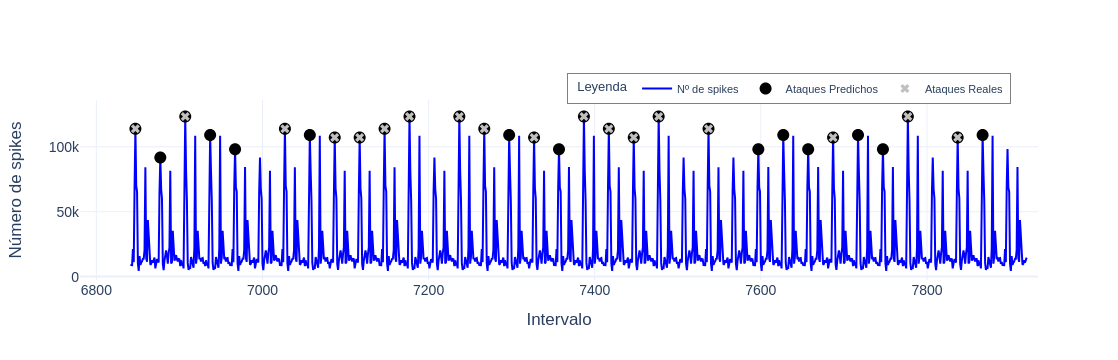

In [84]:
# Convertir y_pred en DataFrame si no lo es
df_y_pred = pd.DataFrame(y_pred, columns=['class'])

# Convertir y_test en DataFrame
df_y_test = y_test.to_frame(name='true_class').reset_index(drop=True)

# Asegurar que X_test tiene el mismo índice que y_test
df_final = X_test.reset_index(drop=True).copy()
df_final['class'] = df_y_pred['class']  # Agregar predicciones
df_final['true_class'] = df_y_test['true_class']  # Agregar valores reales

# Crear la figura con Plotly
fig = go.Figure()

# Agregar la serie de tiempo (línea azul para los spikes) SIN que aparezca en la leyenda
fig.add_trace(go.Scatter(
    x=df_final['interval'],
    y=df_final['spikes'],
    mode='lines',
    name='Nº de spikes',
    line=dict(color='blue')
))

# Filtrar los ataques predichos (class == 1)
df_attacks_pred = df_final[df_final['class'] == 1]

# Agregar los ataques predichos en negro si existen
if not df_attacks_pred.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_pred['interval'],
        y=df_attacks_pred['spikes'],
        mode='markers',
        name='Ataques Predichos',
        marker=dict(color='black', size=12, symbol='circle')
    ))

# Filtrar los ataques reales (true_class == 1)
df_attacks_true = df_final[df_final['true_class'] == 1]

# Agregar los ataques reales en plateado si existen
if not df_attacks_true.empty:
    fig.add_trace(go.Scatter(
        x=df_attacks_true['interval'],
        y=df_attacks_true['spikes'],
        mode='markers',
        name='Ataques Reales',
        marker=dict(color='silver', size=8, symbol='x')  # Puntos plateados
    ))

# Configurar el diseño de la gráfica
fig.update_layout(
    xaxis=dict(
        title="Intervalo",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje X
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje X
    ),
    yaxis=dict(
        title="Número de spikes",
        titlefont=dict(size=17),  # Tamaño más grande del título del eje Y
        tickfont=dict(size=14)  # Tamaño más grande de los ticks del eje Y
    ),
    legend=dict(
        title="  Leyenda",
        font=dict(size=11),
        x=0.74,  # Centrar en la parte inferior
        y=1.15,  # Colocar debajo del gráfico
        xanchor="center",
        yanchor="top",
        bgcolor="rgba(255,255,255,0.8)", 
        bordercolor="gray",  # Color del borde
        borderwidth=1.0,  # Ancho del borde
        orientation="h"  # Leyenda en horizontal
    ),
    template="plotly_white"
)

# Mostrar la gráfica
fig.show()